In [70]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import math
from skimage.metrics import structural_similarity, mean_squared_error

Загрузка и отображение исходного изображения

In [71]:
image = cv2.imread('assets/sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
original_image = image_gray.copy()

def imshow_pair(image1, title1, image2, title2):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    plt.show()

def calculate_metrics(original, filtered):
    mse = mean_squared_error(original, filtered)
    ssim = structural_similarity(original, filtered)
    return mse, ssim

Генерация гауссовского шума

In [72]:
mean = 0
stddev = 100
noise_gauss = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, stddev)
image_gauss = cv2.add(image_gray, noise_gauss)

Генерация равномерного шума

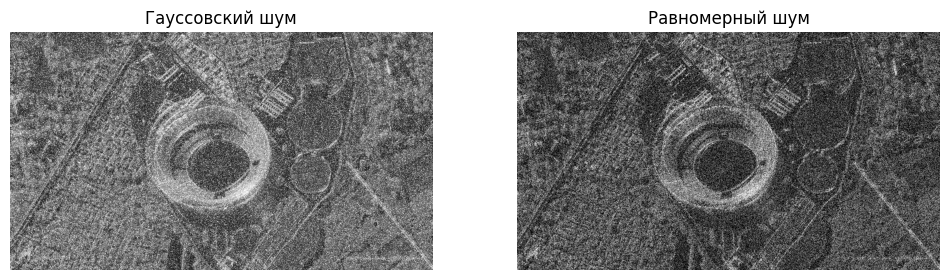

In [73]:
noise_strength = 100
noise_uniform = np.random.uniform(-noise_strength, noise_strength, image_gray.shape)
image_uniform = np.clip(image_gray.astype(np.int16) + noise_uniform, 0, 255).astype(np.uint8)

imshow_pair(image_gauss, 'Гауссовский шум', image_uniform, 'Равномерный шум')

Вычисляем метрики для исходных зашумленных изображений

In [74]:
mse_gauss_orig, ssim_gauss_orig = calculate_metrics(original_image, image_gauss)
mse_uniform_orig, ssim_uniform_orig = calculate_metrics(original_image, image_uniform)

print("Метрики:")
print(f"Гауссовский шум:    MSE = {mse_gauss_orig:.2f}, SSIM = {ssim_gauss_orig:.4f}")
print(f"Равномерный шум:    MSE = {mse_uniform_orig:.2f}, SSIM = {ssim_uniform_orig:.4f}")

Метрики:
Гауссовский шум:    MSE = 4237.40, SSIM = 0.1930
Равномерный шум:    MSE = 2914.06, SSIM = 0.1845


Функция для тестирования фильтров на разных типах шума

In [75]:
def test_filters(noisy_image, noise_type):
    results = {}
    filtered_images = {}

    # Медианный 3x3
    image_median_3 = cv2.medianBlur(noisy_image, 3)
    mse, ssim = calculate_metrics(original_image, image_median_3)
    results['Медианный 3x3'] = {'mse': mse, 'ssim': ssim}
    filtered_images['Медианный 3x3'] = image_median_3

    plt.figure(figsize=(8, 6))
    plt.imshow(image_median_3, cmap='gray')
    plt.title(f'Медианный фильтр 3x3 ({noise_type})\nMSE: {mse:.1f}, SSIM: {ssim:.4f}')
    plt.axis('off')
    plt.show()

    # Медианный 9x9
    image_median_9 = cv2.medianBlur(noisy_image, 9)
    mse, ssim = calculate_metrics(original_image, image_median_9)
    results['Медианный 9x9'] = {'mse': mse, 'ssim': ssim}
    filtered_images['Медианный 9x9'] = image_median_9

    plt.figure(figsize=(8, 6))
    plt.imshow(image_median_9, cmap='gray')
    plt.title(f'Медианный фильтр 9x9 ({noise_type})\nMSE: {mse:.1f}, SSIM: {ssim:.4f}')
    plt.axis('off')
    plt.show()

    # Фильтр Гаусса
    image_gauss = cv2.GaussianBlur(noisy_image, (5, 5), 0)
    mse, ssim = calculate_metrics(original_image, image_gauss)
    results['Гаусс 5x5'] = {'mse': mse, 'ssim': ssim}
    filtered_images['Гаусс 5x5'] = image_gauss

    plt.figure(figsize=(8, 6))
    plt.imshow(image_gauss, cmap='gray')
    plt.title(f'Фильтр Гаусса 5x5 ({noise_type})\nMSE: {mse:.1f}, SSIM: {ssim:.4f}')
    plt.axis('off')
    plt.show()

    # Билатеральный фильтр
    image_bilat = cv2.bilateralFilter(noisy_image, 9, 75, 75)
    mse, ssim = calculate_metrics(original_image, image_bilat)
    results['Билатеральный'] = {'mse': mse, 'ssim': ssim}
    filtered_images['Билатеральный'] = image_bilat

    plt.figure(figsize=(8, 6))
    plt.imshow(image_bilat, cmap='gray')
    plt.title(f'Билатеральный фильтр ({noise_type})\nMSE: {mse:.1f}, SSIM: {ssim:.4f}')
    plt.axis('off')
    plt.show()

    # NLM фильтр
    image_nlm = cv2.fastNlMeansDenoising(noisy_image, h=20)
    mse, ssim = calculate_metrics(original_image, image_nlm)
    results['NLM h=20'] = {'mse': mse, 'ssim': ssim}
    filtered_images['NLM h=20'] = image_nlm

    plt.figure(figsize=(8, 6))
    plt.imshow(image_nlm, cmap='gray')
    plt.title(f'NLM фильтр h=20 ({noise_type})\nMSE: {mse:.1f}, SSIM: {ssim:.4f}')
    plt.axis('off')
    plt.show()

    # Геометрический фильтр
    def geom(a):
        sum_log = 0
        for i in range(a.shape[0]):
            for j in range(a.shape[1]):
                sum_log += math.log(a[i,j] + 1e-8)
        return math.exp(sum_log / (a.shape[0] * a.shape[1]))

    def proc(img, filter_func):
        img_res = copy.deepcopy(img)
        for i in range(0, img.shape[0] - 2):
            for j in range(0, img.shape[1] - 2):
                img_res[i+1, j+1] = filter_func(img[i:i+3, j:j+3])
        return img_res

    image_geom = proc(noisy_image, geom)
    mse, ssim = calculate_metrics(original_image, image_geom)
    results['Геометрический'] = {'mse': mse, 'ssim': ssim}
    filtered_images['Геометрический'] = image_geom

    plt.figure(figsize=(8, 6))
    plt.imshow(image_geom, cmap='gray')
    plt.title(f'Геометрический фильтр ({noise_type})\nMSE: {mse:.1f}, SSIM: {ssim:.4f}')
    plt.axis('off')
    plt.show()

    # Лапласиан фильтр
    kernel_lapl = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], np.float32)
    image_lapl = cv2.filter2D(noisy_image, -1, kernel_lapl)
    mse, ssim = calculate_metrics(original_image, image_lapl)
    results['Лапласиан'] = {'mse': mse, 'ssim': ssim}
    filtered_images['Лапласиан'] = image_lapl

    plt.figure(figsize=(8, 6))
    plt.imshow(image_lapl, cmap='gray')
    plt.title(f'Лапласиан фильтр ({noise_type})\nMSE: {mse:.1f}, SSIM: {ssim:.4f}')
    plt.axis('off')
    plt.show()

    return results, filtered_images

Фильтры на гауссовском шуме

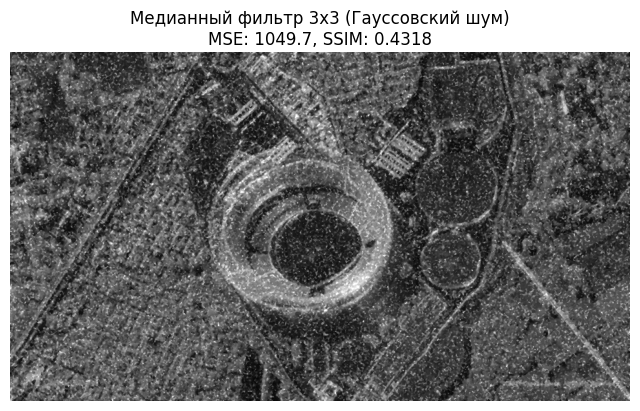

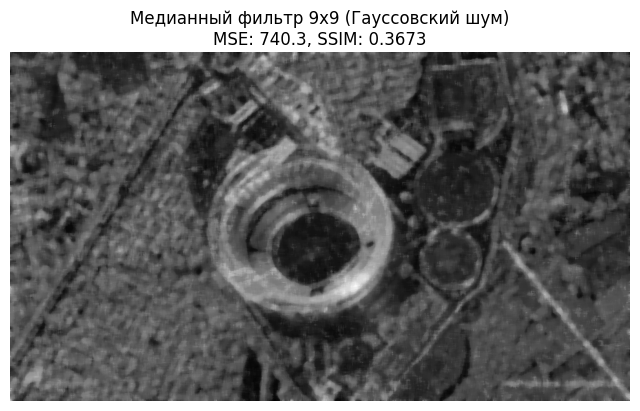

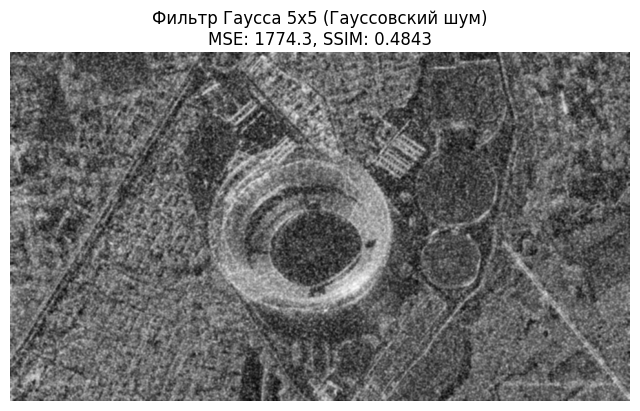

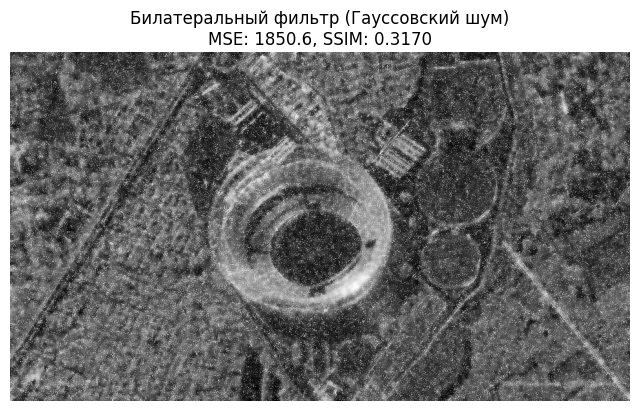

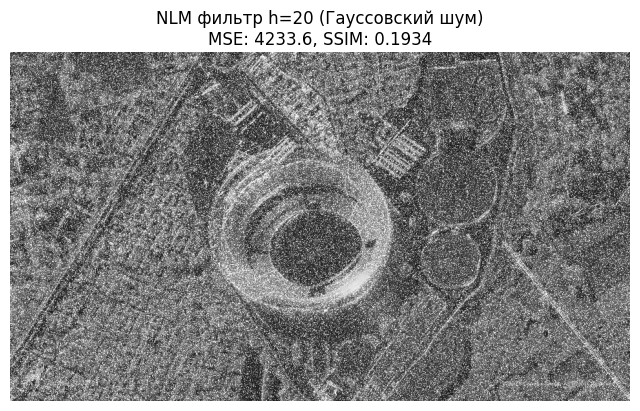

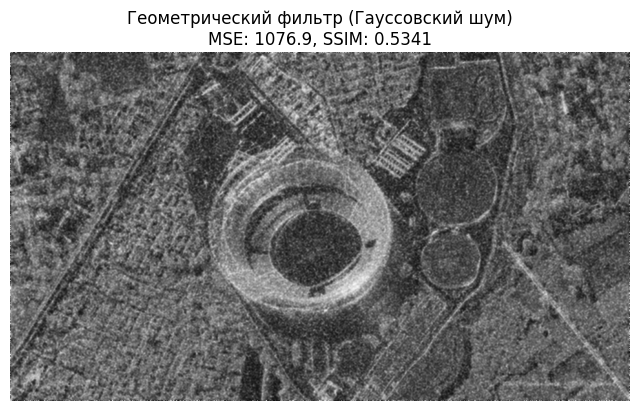

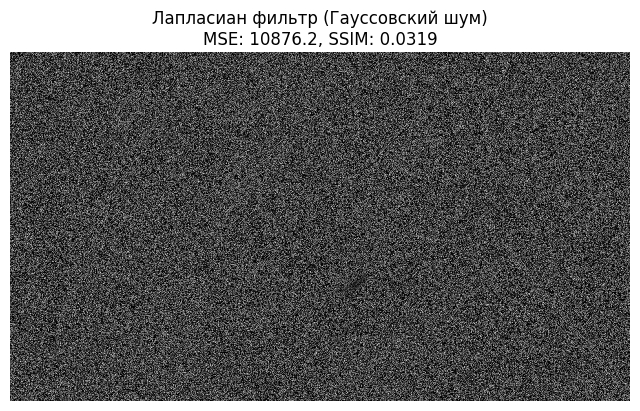


Результаты фильтрации гауссовского шума:
Медианный 3x3   | MSE: 1049.66 | SSIM: 0.4318
Медианный 9x9   | MSE:  740.34 | SSIM: 0.3673
Гаусс 5x5       | MSE: 1774.33 | SSIM: 0.4843
Билатеральный   | MSE: 1850.57 | SSIM: 0.3170
NLM h=20        | MSE: 4233.57 | SSIM: 0.1934
Геометрический  | MSE: 1076.94 | SSIM: 0.5341
Лапласиан       | MSE: 10876.16 | SSIM: 0.0319

Лучший по MSE:  Медианный 9x9 (MSE = 740.34)
Лучший по SSIM: Геометрический (SSIM = 0.5341)


In [76]:
results_gauss, filtered_gauss = test_filters(image_gauss, "Гауссовский шум")

best_mse_gauss = float('inf')
best_ssim_gauss = -float('inf')
best_filter_mse_gauss = None
best_filter_ssim_gauss = None

print("\nРезультаты фильтрации гауссовского шума:")
for name, metrics in results_gauss.items():
    mse, ssim = metrics['mse'], metrics['ssim']
    print(f"{name:15} | MSE: {mse:7.2f} | SSIM: {ssim:.4f}")

    if mse < best_mse_gauss:
        best_mse_gauss = mse
        best_filter_mse_gauss = name
    if ssim > best_ssim_gauss:
        best_ssim_gauss = ssim
        best_filter_ssim_gauss = name

print(f"\nЛучший по MSE:  {best_filter_mse_gauss} (MSE = {best_mse_gauss:.2f})")
print(f"Лучший по SSIM: {best_filter_ssim_gauss} (SSIM = {best_ssim_gauss:.4f})")

Фильтры на равномерном шуме

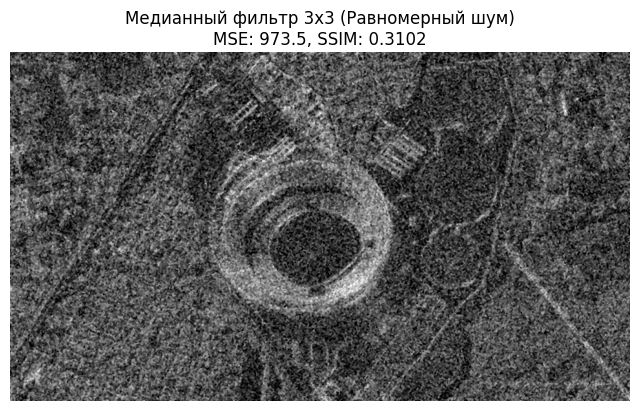

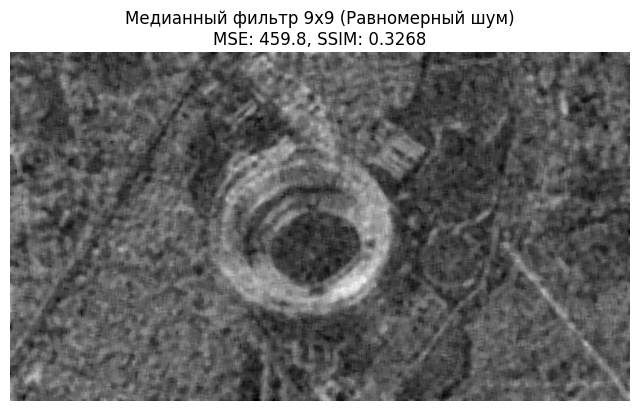

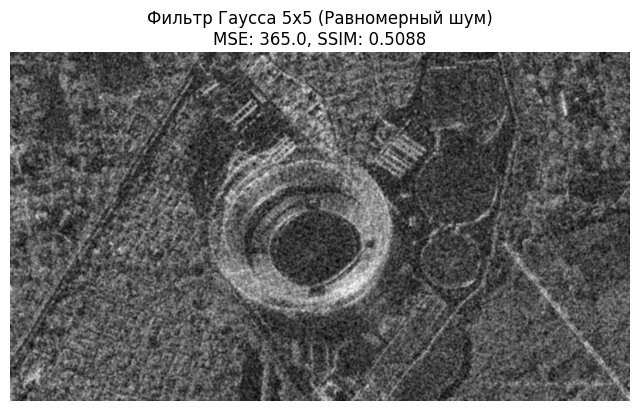

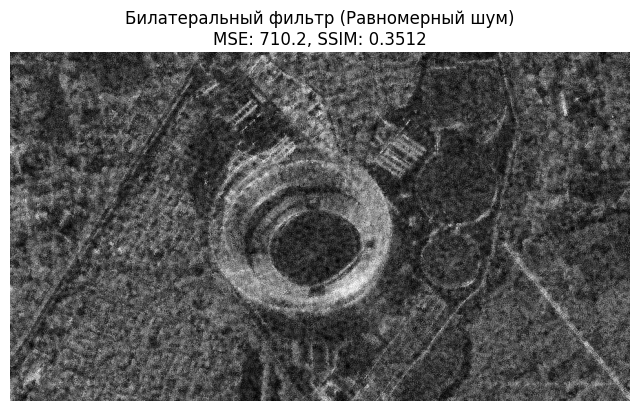

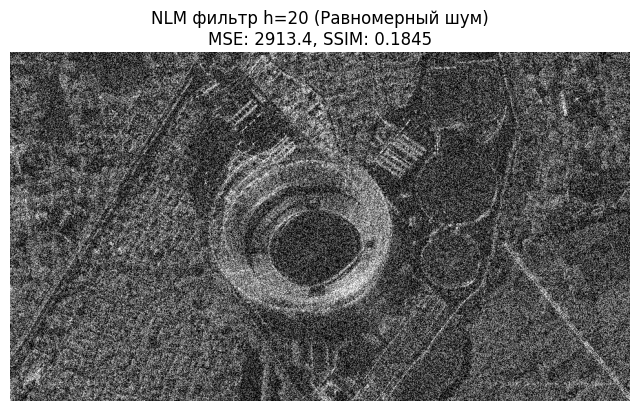

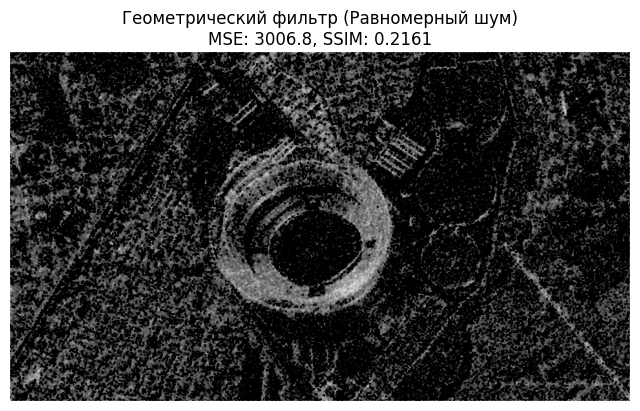

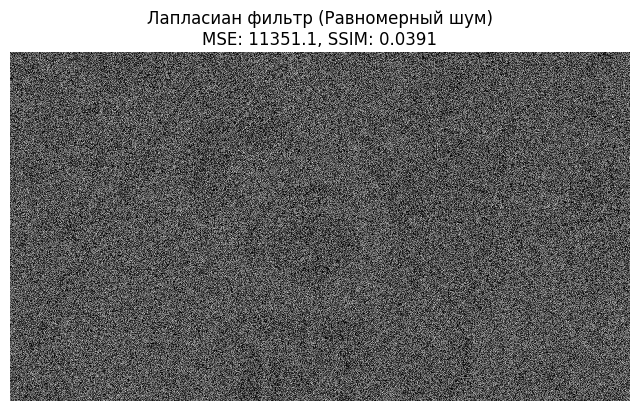


Результаты фильтрации равномерного шума:
Медианный 3x3   | MSE:  973.54 | SSIM: 0.3102
Медианный 9x9   | MSE:  459.76 | SSIM: 0.3268
Гаусс 5x5       | MSE:  365.05 | SSIM: 0.5088
Билатеральный   | MSE:  710.19 | SSIM: 0.3512
NLM h=20        | MSE: 2913.36 | SSIM: 0.1845
Геометрический  | MSE: 3006.84 | SSIM: 0.2161
Лапласиан       | MSE: 11351.12 | SSIM: 0.0391

Лучший по MSE:  Гаусс 5x5 (MSE = 365.05)
Лучший по SSIM: Гаусс 5x5 (SSIM = 0.5088)


In [77]:
results_uniform, filtered_uniform = test_filters(image_uniform, "Равномерный шум")

best_mse_uniform = float('inf')
best_ssim_uniform = -float('inf')
best_filter_mse_uniform = None
best_filter_ssim_uniform = None

print("\nРезультаты фильтрации равномерного шума:")
for name, metrics in results_uniform.items():
    mse, ssim = metrics['mse'], metrics['ssim']
    print(f"{name:15} | MSE: {mse:7.2f} | SSIM: {ssim:.4f}")

    if mse < best_mse_uniform:
        best_mse_uniform = mse
        best_filter_mse_uniform = name
    if ssim > best_ssim_uniform:
        best_ssim_uniform = ssim
        best_filter_ssim_uniform = name

print(f"\nЛучший по MSE:  {best_filter_mse_uniform} (MSE = {best_mse_uniform:.2f})")
print(f"Лучший по SSIM: {best_filter_ssim_uniform} (SSIM = {best_ssim_uniform:.4f})")

Итоговое сравнение

In [78]:
print("\nСравнение типов шума:")
print(f"Гауссовский шум:    MSE = {mse_gauss_orig:.2f}, SSIM = {ssim_gauss_orig:.4f}")
print(f"Равномерный шум:    MSE = {mse_uniform_orig:.2f}, SSIM = {ssim_uniform_orig:.4f}")

print("\nЭффективность фильтрации:")
print(f"Гауссовский шум - лучший фильтр: {best_filter_ssim_gauss}")
print(f"Равномерный шум - лучший фильтр: {best_filter_ssim_uniform}")

best_gauss_image = None
if best_filter_ssim_gauss == 'Медианный 3x3':
    best_gauss_image = cv2.medianBlur(image_gauss, 3)
elif best_filter_ssim_gauss == 'Медианный 9x9':
    best_gauss_image = cv2.medianBlur(image_gauss, 9)
elif best_filter_ssim_gauss == 'Гаусс 5x5':
    best_gauss_image = cv2.GaussianBlur(image_gauss, (5, 5), 0)
elif best_filter_ssim_gauss == 'Билатеральный':
    best_gauss_image = cv2.bilateralFilter(image_gauss, 9, 75, 75)
elif best_filter_ssim_gauss == 'NLM h=20':
    best_gauss_image = cv2.fastNlMeansDenoising(image_gauss, h=20)

best_uniform_image = None
if best_filter_ssim_uniform == 'Медианный 3x3':
    best_uniform_image = cv2.medianBlur(image_uniform, 3)
elif best_filter_ssim_uniform == 'Медианный 9x9':
    best_uniform_image = cv2.medianBlur(image_uniform, 9)
elif best_filter_ssim_uniform == 'Гаусс 5x5':
    best_uniform_image = cv2.GaussianBlur(image_uniform, (5, 5), 0)
elif best_filter_ssim_uniform == 'Билатеральный':
    best_uniform_image = cv2.bilateralFilter(image_uniform, 9, 75, 75)
elif best_filter_ssim_uniform == 'NLM h=20':
    best_uniform_image = cv2.fastNlMeansDenoising(image_uniform, h=20)

if best_gauss_image is not None and best_uniform_image is not None:
    imshow_pair(best_gauss_image, f'Гауссовский шум: {best_filter_ssim_gauss}',
                best_uniform_image, f'Равномерный шум: {best_filter_ssim_uniform}')


Сравнение типов шума:
Гауссовский шум:    MSE = 4237.40, SSIM = 0.1930
Равномерный шум:    MSE = 2914.06, SSIM = 0.1845

Эффективность фильтрации:
Гауссовский шум - лучший фильтр: Геометрический
Равномерный шум - лучший фильтр: Гаусс 5x5
